# Import modules

In [80]:
# Data science tools
import numpy as np
import pandas as pd
import os
import random
from glob import glob
import time 
from time import sleep, time
import pickle
import joblib

# ML tools
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from tqdm import tqdm
from mlxtend.preprocessing import shuffle_arrays_unison

from sklearn.decomposition import PCA


# Image manipulations
import cv2
from PIL import Image
import skimage
from skimage import transform
from skimage.color import rgb2gray

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Explore the whole Data

In [19]:
# directories
datadir = './data/'
traindir = datadir + 'train/'
validdir = datadir + 'val/'
testdir = datadir + 'test/'
datasetdir = datadir + 'DataSet/' # smaller dataset of 8000 images 

In [20]:
train_imgs = os.listdir(traindir)
print(train_imgs[:5])

['CNV', 'DME', 'DRUSEN', 'NORMAL']


In [21]:
# Empty lists
categories = []
img_categories = []
n_train = []
n_valid = []
n_test = []
hs = []
ws = []

# Iterate through each category ie ['CNV', 'DME', 'DRUSEN', 'NORMAL']
for d in os.listdir(traindir):
    categories.append(d)

    # Number of each image
    train_imgs = os.listdir(traindir + d)
    valid_imgs = os.listdir(validdir + d)
    test_imgs = os.listdir(testdir + d)
    n_train.append(len(train_imgs))
    n_valid.append(len(valid_imgs))
    n_test.append(len(test_imgs))

    # Find stats for train images
    for i in train_imgs:
        img_categories.append(d)
        img = Image.open(traindir + d + '/' + i)
        img_array = np.array(img)
        # Shape
        hs.append(img_array.shape[0])
        ws.append(img_array.shape[1])

# Dataframe of categories
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid, 'n_test': n_test}).\
    sort_values('category')

# Dataframe of training images
image_df = pd.DataFrame({
    'category': img_categories,
    'height': hs,
    'width': ws
})

In [22]:
cat_df.sort_values('n_train', ascending=False, inplace=True)
cat_df.head()

,category,n_train,n_valid,n_test
0,CNV,30205,8,242
3,NORMAL,24315,8,242
1,DME,9348,8,242
2,DRUSEN,6616,8,242


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Training Images by Category')

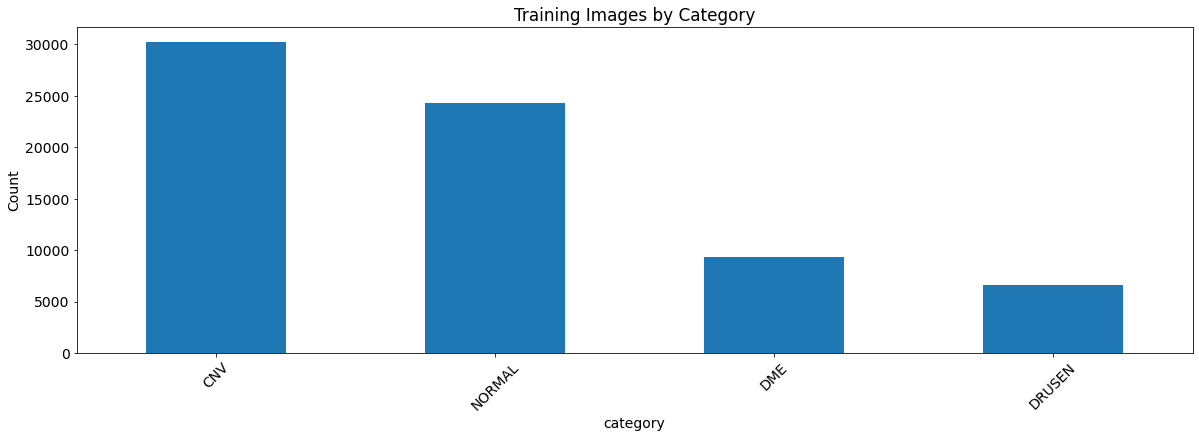

In [23]:
cat_df.set_index('category')['n_train'].plot.bar(figsize=(20, 6))
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('Training Images by Category')
plt.show()

In [24]:
image_df.head()

,category,height,width
0,CNV,496,768
1,CNV,496,768
2,CNV,496,768
3,CNV,496,768
4,CNV,496,768


# Explore my smaller dataset (8000 images ; 2000 images of each category)

In [25]:
# Find stats for DataSet images
dataset_hs=[]
dataset_ws=[]
img_names=[]
img_categories = []
# iterate trought each image
for f in os.listdir(datasetdir):
    #print(f)
    img_names.append(f)
    img_categories.append(os.path.basename(f).split('-')[0])
    img = Image.open(datasetdir + '/' + f)
    img_array = np.array(img)
    # Shape
    dataset_hs.append(img_array.shape[0])
    dataset_ws.append(img_array.shape[1])
    

## Details about images dimensions

In [26]:
# Dataframe of datasetimages
dataset_image_df = pd.DataFrame({
    'name': img_names,
    'category' : img_categories,
    'height': dataset_hs,
    'width': dataset_ws
})
dataset_image_df.head()

,name,category,height,width
0,CNV-172472-396.jpeg,CNV,496,768
1,CNV-172472-397.jpeg,CNV,496,1536
2,CNV-172472-398.jpeg,CNV,496,1536
3,CNV-172472-399.jpeg,CNV,496,1536
4,CNV-172472-4.jpeg,CNV,496,768


In [27]:
dataset_image_df.groupby('category').describe()

height                                                        \
           count     mean       std    min    25%    50%    75%    max   
category                                                                 
CNV       2000.0  496.000  0.000000  496.0  496.0  496.0  496.0  496.0   
DME       2000.0  506.440  7.620724  496.0  496.0  512.0  512.0  512.0   
DRUSEN    2000.0  496.000  0.000000  496.0  496.0  496.0  496.0  496.0   
NORMAL    2000.0  503.632  7.993530  496.0  496.0  496.0  512.0  512.0   

           width                                                           
           count     mean         std    min    25%    50%    75%     max  
category                                                                   
CNV       2000.0  708.544  315.534361  384.0  512.0  512.0  768.0  1536.0  
DME       2000.0  584.448  223.218370  512.0  512.0  512.0  512.0  1536.0  
DRUSEN    2000.0  660.096  288.551066  512.0  512.0  512.0  768.0  1536.0  
NORMAL    2000.0  618.880  254.032257  512.0  512.0  512.0  512.0  1536.0

## Some images

(496, 768)


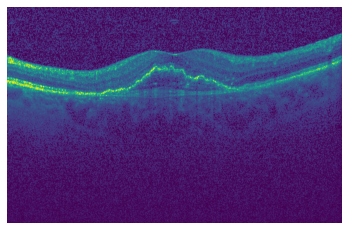

In [28]:
def imshow(image):
    """Display image"""
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


# Example image
x = Image.open(datasetdir + 'CNV-172472-396.jpeg')
print(np.array(x).shape)
imshow(x)

In [29]:
# plot multiple images with cv2
def plotThreeImages(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2]))
    plt.show(); 


Normal


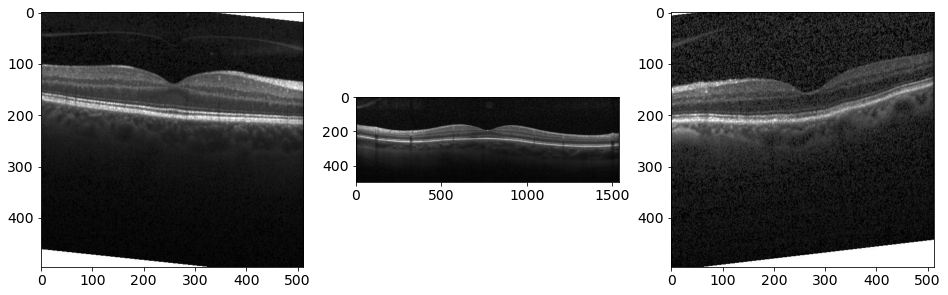

----------------------------------------
CNV


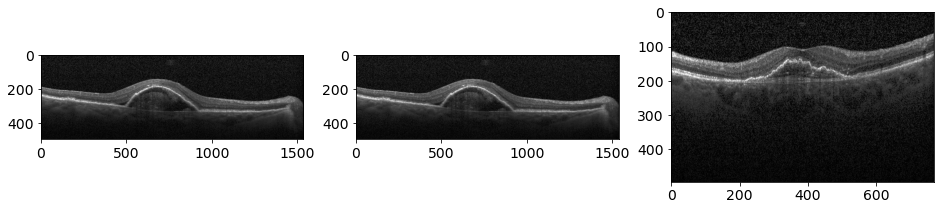

----------------------------------------
DME


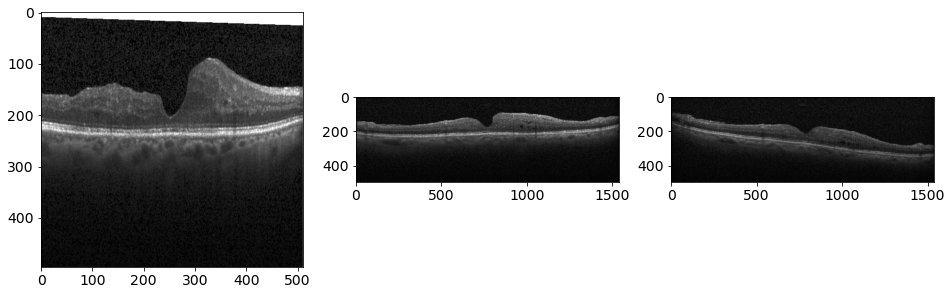

----------------------------------------
DRUSEN


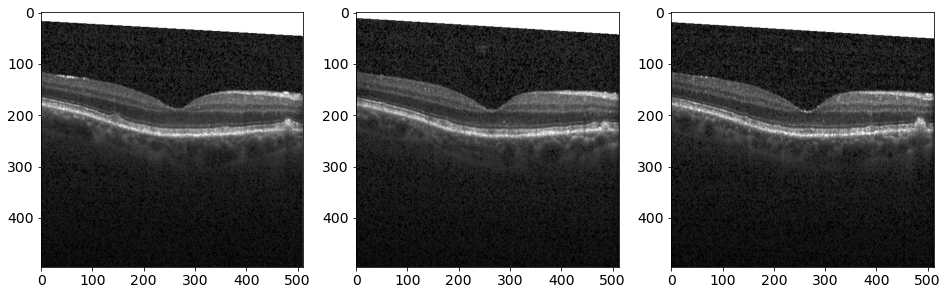

In [30]:
print("Normal")
plotThreeImages(glob(datasetdir+'/NORMAL-**')[:3])
print('----------------------------------------')
print("CNV")
plotThreeImages(glob(datasetdir+'/CNV-**')[:3])
print('----------------------------------------')
print("DME")
plotThreeImages(glob(datasetdir+'/DME-**')[:3])
print('----------------------------------------')
print("DRUSEN")
plotThreeImages(glob(datasetdir+'/DRUSEN-**')[:3])

Rmq : skyimage vs cv2 =>  OpenCV and skimage use a fundamentally different representation of images. OpenCV tends to prefer 8-bit unsigned integers in range [0..255] and skimage tends to use floats in range [0..1].

(496, 768, 3)


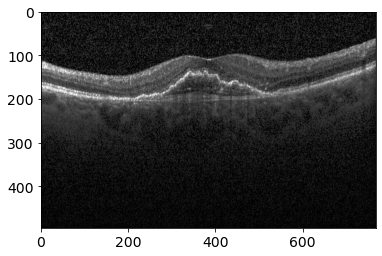

(496, 768)


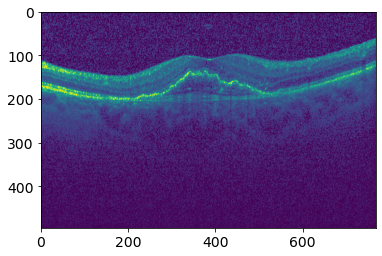

In [31]:
image = cv2.imread(datasetdir + '/CNV-172472-396.jpeg')
print(image.shape)
plt.imshow(image)
plt.show()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(gray.shape)
plt.imshow(gray)


# pre-processing images : resizing + grayscale

In [32]:

imgSize = 150

def resize_data(image_file_list):
    """
    load and resize the data with skimage and save the file name 
    """
    
    # Define empty arrays where we will store our images, their categorie and file name
    images = []
    names = []
    categories = []
    
    for f in tqdm(image_file_list):
        
        # Add image category (collected by splitting the file name) to categories array 
        categories.append(os.path.basename(f).split('-')[0])
        
        # Add file name to img_name
        names.append(f)
        
        # Read the image
        img_file = cv2.imread(datasetdir + '/' + f)
        
        # convert to grayscale
        gray = cv2.cvtColor(img_file, cv2.COLOR_BGR2GRAY)
        
        # Resize it to imgSize
        image = skimage.transform.resize(gray, (imgSize, imgSize))
        
        # Add preprocessed image to X array
        images.append(image)
        
    # transform to array 
    images = np.array(images)
    return images, categories, names


In [33]:
resized_images, categories, names = resize_data(img_names)

100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [02:31<00:00, 52.71it/s]


In [34]:
# checking size of the data resized
resized_images.shape
len(categories)

# Checking the minimum and maximum values of X
print(resized_images.min())
print(resized_images.max())

(8000, 150, 150)

8000

0.0
1.0


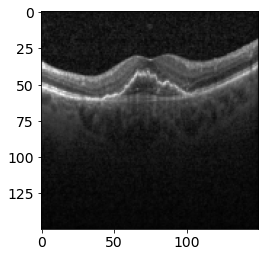

In [35]:
# one example of resized image
plt.imshow(resized_images[0], cmap = plt.cm.gray)

# Shuffle and  Save Data

## to df

In [ ]:
d = {'image': pd.Series(resized_images.tolist()), 'category': categories, 'file_name': names}
#shuffle_arrays_unison(arrays=[resized_images, img_cat, img_name], random_seed=0)
df = pd.DataFrame(data=d)

In [52]:
df.head()

,image,category,file_name
0,"[[0.08352941176470838, 0.047058823529411764, 0...",CNV,CNV-172472-396.jpeg
1,"[[0.08352941176470838, 0.047058823529411764, 0...",CNV,CNV-172472-397.jpeg
2,"[[0.08352941176470838, 0.047058823529411764, 0...",CNV,CNV-172472-398.jpeg
3,"[[0.08352941176470838, 0.047058823529411764, 0...",CNV,CNV-172472-399.jpeg
4,"[[0.08352941176470838, 0.047058823529411764, 0...",CNV,CNV-172472-4.jpeg


## to dictionnary 

In [36]:
def shuffle_and_save(images, categories, names, savedir):
    """
    shuffle the preprocessed images and save it into a dictionnary as well as their category and file name
    """

    # shuffle data
    images, categories, names = shuffle_arrays_unison(arrays=[resized_images, categories, names], random_seed=0)

    # Add them to a dictionnary
    dictionnary = {'images': images, 'categories': categories, 'names': names}

    # Save it 
    if not os.path.exists(savedir):
        os.makedirs(savedir)
    with open(savedir + 'preprocessed_data' +'.pickle',"wb") as outpout:
        pickle.dump(d, outpout)

      
    return dictionnary 

In [43]:
savedir = './save/'
data = shuffle_and_save(np.array(resized_images), np.array(categories), np.array(names), savedir)

In [40]:
# load a existing data dictionnary
# savedir = './save/'
# with open(savedir+'preprocessed_data.pickle', 'rb') as data:
#     data = pickle.load(data)

In [44]:
data.keys()

dict_keys(['images', 'categories', 'names'])

In [45]:
for key in data.keys():
    globals()[str(key)] =data[key]

# PCA 

In [46]:
# split into train and test  and shuffle the data 
train, test, train_cat, test_cat  = train_test_split(images.reshape(len(images),-1),category, test_size=0.2, random_state=0)

In [47]:
print("train size {}".format(train.shape))
print("test size {}".format(test.shape) )

X train size (6400, 22500)
X test size (1600, 22500)


Extracting the top 0 eigenOCT from 6400 retina OCT
done in 592.511s
[STATUS] n components =  257
Projecting the input data on the eigenvectors orthonormal basis
done in 0.000s


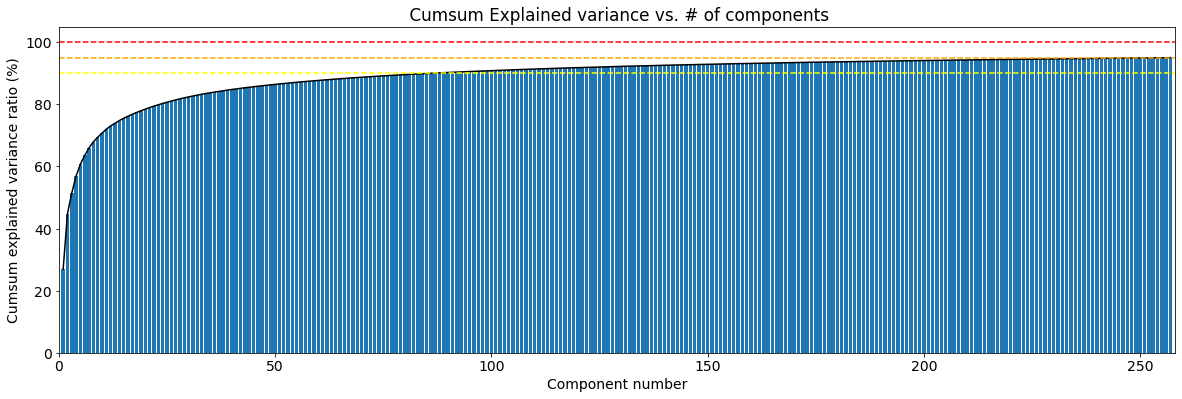

In [52]:
# PCA 
#--------------------
# tunable-parameters
#--------------------
n_samples, h, w = images.shape
n_components =0.95


### Running PCA by keeping 95% of variance explained ###
pca=PCA(n_components=n_components , svd_solver='full', whiten=True)
#pca=PCA(n_components=n_components, svd_solver='randomized', whiten=True)

print("Extracting the top %d eigenOCT from %d retina OCT" % (n_components, train.shape[0]))
t0 = time()

pca = pca.fit(train[:])
print("done in %0.3fs" % (time() - t0))

n_components=pca.n_components_
print("[STATUS] n components =  {}".format(n_components) )
eigenvectors = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenvectors orthonormal basis")
t0 = time()

print("done in %0.3fs" % (time() - t0))

#cumul de variance expliquée
plt.figure(figsize=(20,6))
plt.plot(np.arange(1,n_components+1),np.cumsum(pca.explained_variance_ratio_)*100, color='black')
plt.bar(np.arange(1,n_components+1),np.cumsum(pca.explained_variance_ratio_)*100)
plt.axhline(y=90, color='yellow', linestyle='--')
plt.axhline(y=95, color='orange', linestyle='--')
plt.axhline(y=100, color='r', linestyle='--')
plt.title(" Cumsum Explained variance vs. # of components")
plt.xlim(0,n_components+1)

plt.ylabel("Cumsum explained variance ratio (%)")
plt.xlabel("Component number")
plt.show();

In [56]:
# transfrom the train set 
t0 = time()
train_pca = pca.transform(train[:])
print("done in %0.3fs" % (time() - t0))


done in 2.019s


In [57]:
# transfrom the train set 
t0 = time()
test_pca = pca.transform(train[:])
print("done in %0.3fs" % (time() - t0))

done in 2.061s


In [58]:
print("train size after PCA {}".format(train_pca.shape))
print("test size  after PCA {}".format(test_pca.shape) )

train size after PCA (6400, 257)
test size  after PCA (6400, 257)


# Building the model - Kmeans

In [61]:
# convert each image to 1 dimensional array
train_flat = train.reshape(len(train),-1)

# Checking the size
train_flat.shape

(6400, 22500)

## Run model

###  model using PCA

In [77]:
total_clusters = 4

# Initialize the K-Means model
kmeans_pca = KMeans(n_clusters = total_clusters, random_state=0)

# Fit the model to the training data
t0 = time()
kmeans_pca.fit(train_pca)
print("done in %0.3fs" % (time() - t0))


KMeans(n_clusters=4, random_state=0)

done in 6.405s


In [78]:
kmeans_pca.labels_

array([3, 3, 3, ..., 3, 3, 1])

### Model not using PCA

In [75]:
total_clusters = 4

# Initialize the K-Means model
kmeans = KMeans(n_clusters = total_clusters, random_state=0)

# Fit the model to the training data
t0 = time()
kmeans.fit(train_flat)
print("done in %0.3fs" % (time() - t0))


KMeans(n_clusters=4, random_state=0)

done in 51.465s


In [76]:
kmeans.labels_

array([2, 2, 1, ..., 0, 0, 1])

## Silhouette scores : higher the best

### PCA

In [92]:
K = range(2,7)
Silhouette_scores=[]
for k in K:
    km = KMeans(n_clusters=k,init='k-means++',random_state=0)
    preds = km.fit_predict(train_pca)
    centers = km.cluster_centers_
    score = silhouette_score(train_pca, preds)
    print("For n_clusters = {}, silhouette score is {}".format(k, score))
    Silhouette_scores.append(score)

For n_clusters = 2, silhouette score is 0.24869927540403403
For n_clusters = 3, silhouette score is -0.033390821488727254
For n_clusters = 4, silhouette score is -0.01756915677051192
For n_clusters = 5, silhouette score is -0.02571237767996356
For n_clusters = 6, silhouette score is -0.020201976911048813


In [93]:
# I do it in 5000 samples because of memory issue
K = range(2,7)
Silhouette_scores=[]
for k in K:
    km = KMeans(n_clusters=k,init='k-means++',random_state=0)
    preds = km.fit_predict(train[5000:])
    centers = km.cluster_centers_
    score = silhouette_score(train[5000:], preds)
    print("For n_clusters = {}, silhouette score is {}".format(k, score))
    Silhouette_scores.append(score)

For n_clusters = 2, silhouette score is 0.3487628639055572
For n_clusters = 3, silhouette score is 0.31422585096391814
For n_clusters = 4, silhouette score is 0.2293403949429323
For n_clusters = 5, silhouette score is 0.23094338567530698
For n_clusters = 6, silhouette score is 0.19930350451050402


##  Assigning Cluster Labels
K-means clustering is an unsupervised machine learning method; consequently, the labels assigned by our KMeans algorithm refer to the cluster each array was assigned to, not the actual target integer. To fix this, let’s define a few functions that will predict which integer corresponds to each cluster.

In [ ]:
def infer_cluster_labels(kmeans, actual_labels):
    inferred_labels = {}

for i in range(kmeans.n_clusters):

    # find index of points in cluster
    labels = []
    index = np.where(kmeans.labels_ == i)

    # append actual labels for each point in cluster
    labels.append(actual_labels[index])

    # determine most common label
    if len(labels[0]) == 1:
        counts = np.bincount(labels[0])
    else:
        counts = np.bincount(np.squeeze(labels))

    # assign the cluster to a value in the inferred_labels dictionary
    if np.argmax(counts) in inferred_labels:
        # append the new number to the existing array at this slot
        inferred_labels[np.argmax(counts)].append(i)
    else:
        # create a new array in this slot
        inferred_labels[np.argmax(counts)] = [i]

    #print(labels)
    #print('Cluster: {}, label: {}'.format(i, np.argmax(counts)))
    
return inferred_labels

def infer_data_labels(X_labels, cluster_labels):
  # empty array of len(X)
predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)

for i, cluster in enumerate(X_labels):
    for key, value in cluster_labels.items():
        if cluster in value:
            predicted_labels[i] = key
            
return predicted_labels

# test the infer_cluster_labels() and infer_data_labels() functions

cluster_labels = infer_cluster_labels(kmeans, Y)
X_clusters = kmeans.predict(X)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)
print predicted_labels[:20]
print Y[:20]